The available models are:

regression: 

Gaussian process regression (GPR)
scalable GPs: subset of data (SoD), ensemble SoD, Nystrom approximation, Naive local experts(NLE).
support vector machine

classifications:
Gaussian process classification (GPC)
support vector machine

# Regression

In [1]:
# Dataset.
from mgktools.data.data import Dataset
dataset = Dataset.load(path='freesolv', filename='dataset.pkl')
dataset.graph_kernel_type = 'pre-computed'
from mgktools.data import dataset_split
train, test = dataset_split(dataset,
                            split_type='random',
                            sizes=[0.8, 0.2])

In [2]:
# Kernel
from mgktools.kernels.utils import get_kernel_config
kernel_config = get_kernel_config(
    dataset,
    graph_kernel_type = 'pre-computed',
    kernel_pkl = 'freesolv/kernel.pkl'
)
kernel = kernel_config.kernel

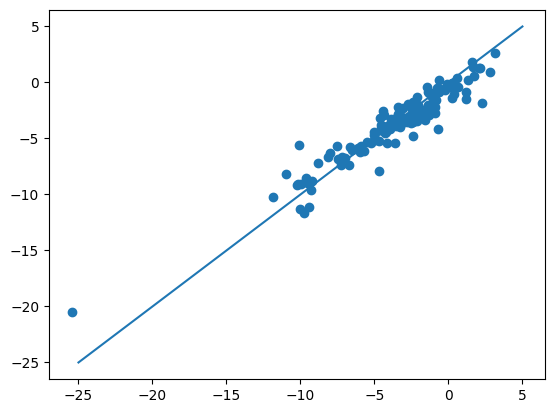

In [3]:
# Gaussian process regression
from mgktools.models.regression.GPRgraphdot import GPR
gpr = GPR(kernel=kernel,
          optimizer=None,
          alpha=0.01,
          normalize_y=True)
gpr.fit(train.X, train.y)
y_pred = gpr.predict(test.X)
import matplotlib.pyplot as plt
plt.scatter(test.y, y_pred)
plt.plot([-25, 5], [-25, 5])

/media/yanxiang/workspace/Github/mgktools/mgktools/models/regression/consensus.py:113: RuntimeWarning: Mean of empty slice.
  return y.mean(axis=0), u.mean(axis=0)
/home/yanxiang/apps/miniforge3/envs/mgktools/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


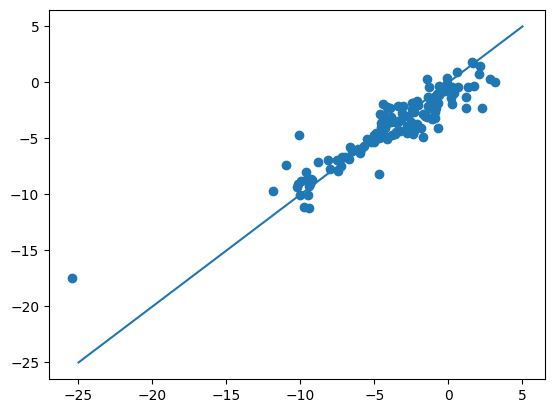

In [4]:
# Subset of Data (SoD) Gaussian process regression
from mgktools.models.regression import ConsensusRegressor
sod = ConsensusRegressor(
    gpr,
    n_estimators=1,
    n_sample_per_model=200,
    n_jobs=1,
    consensus_rule='mean'
)
sod.fit(train.X, train.y)
y_pred = sod.predict(test.X)
plt.scatter(test.y, y_pred)
plt.plot([-25, 5], [-25, 5])

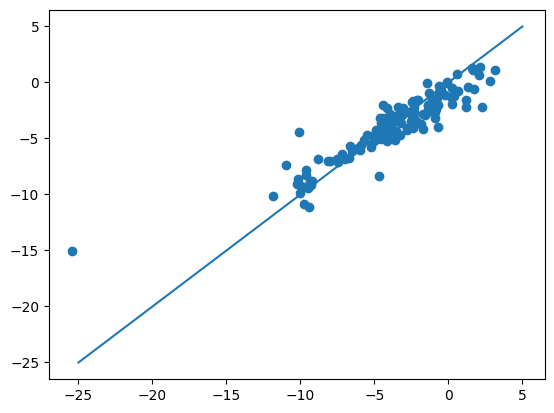

In [5]:
# Ensemble SoD
from mgktools.models.regression import ConsensusRegressor
sod = ConsensusRegressor(
    gpr,
    n_estimators=2,
    n_sample_per_model=200,
    n_jobs=1,
    consensus_rule='mean'
)
sod.fit(train.X, train.y)
y_pred = sod.predict(test.X)
plt.scatter(test.y, y_pred)
plt.plot([-25, 5], [-25, 5])

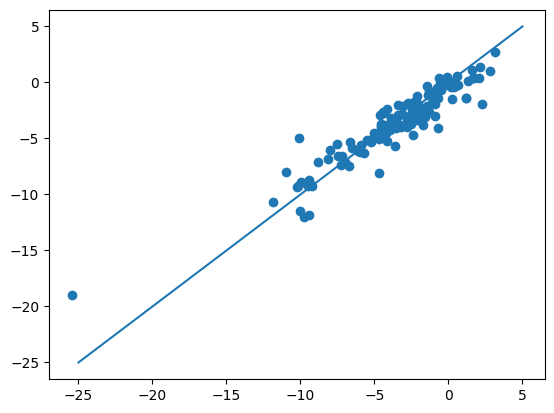

In [6]:
# Nystrom approximation GPR.
from mgktools.models.regression.ScalableGPR import LRAGPR
model = LRAGPR(
    kernel=kernel,
    optimizer=None,
    alpha=0.01,
    normalize_y=True
)
core, _ = dataset_split(train, 
                        split_type='random',
                        sizes=[0.5, 0.5])
model.fit(core.X, train.X, train.y)
y_pred = model.predict(test.X)
plt.scatter(test.y, y_pred)
plt.plot([-25, 5], [-25, 5])

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


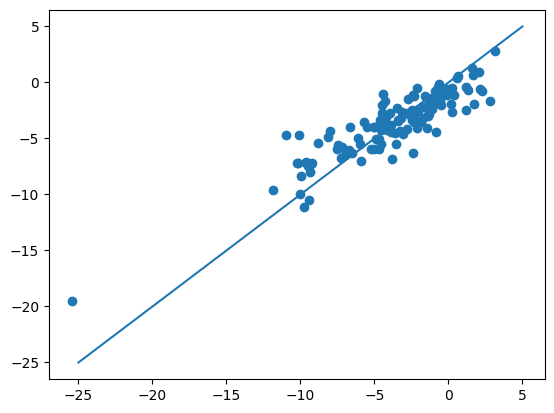

In [7]:
# Naive Local Experts. GPR
from mgktools.models.regression.ScalableGPR import NLEGPR
model = NLEGPR(
    kernel=kernel,
    alpha=0.01,
    n_local=5,
    n_jobs=1, # must be 1 for mgk. could be larger for pre-computed kernel.
)
model.fit(train.X, train.y)
y_pred = model.predict(test.X)
y_pred, y_std = model.predict(test.X, return_std=True)
plt.scatter(test.y, y_pred)
plt.plot([-25, 5], [-25, 5])

/home/yanxiang/apps/miniforge3/envs/mgktools/lib/python3.10/site-packages/sklearn/svm/_base.py:292: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64, copy=False)


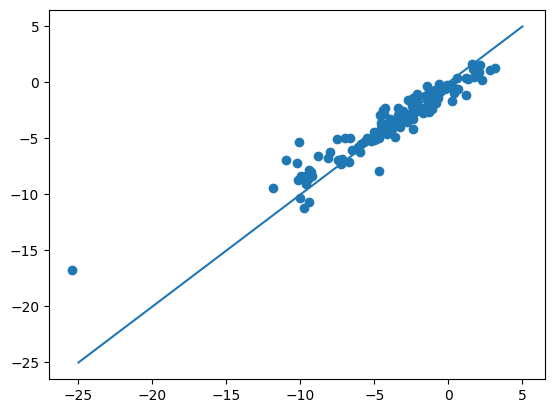

In [8]:
# support vector machine regression
from mgktools.models.regression import SVR
svr = SVR(
    kernel=kernel,
    C=10.0,
)
svr.fit(train.X, train.y)
y_pred = svr.predict(test.X)
plt.scatter(test.y, y_pred)
plt.plot([-25, 5], [-25, 5])

# Classification

In [9]:
# Dataset
import pandas as pd
df = pd.read_csv('../datasets/bbbp.csv')
from mgktools.data.data import Dataset
dataset = Dataset.from_df(
    df,
    pure_columns = ['smiles'],
    target_columns = ['p_np'],
    n_jobs = 8
)
import os
if not os.path.exists('bbbp'):
    os.mkdir('bbbp')
dataset.save(path='bbbp', filename='dataset.pkl', overwrite=True)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[16:20:50] WARNING: not removing hydrogen atom without neighbors
[16:20:50] WARNING: not removing hydrogen atom without neighbors
[16:20:51] WARNING: not removing hydrogen atom without neighbors
[16:20:51] WARNING: not removing hydrogen atom without neighbors
[16:20:51] WARNING: not removing hydrogen atom without neighbors
[16:20:51] WARNING: not removing hydrogen atom without neighbors
[16:20:51] WARNING: not removing hydrogen atom without neighbors
[16:20:53] WARNING: not removing hydrogen atom without neighbors
[16:20:53] WARNING: not removing hydrogen atom without neighbors
[16:20:53] WARNING: not removing hydrogen atom without neighbors
[16:20:53] WARNING: not removing hydrogen atom without neighbors
[16:20:54] WARNING: not removing hydrogen atom without neighbors
[16:20:54] WARNING: not removing hydrogen atom without neighbors
[16:20:55] WARNING:

In [10]:
# Kernel
from mgktools.kernels.utils import get_kernel_config
from mgktools.hyperparameters import product_msnorm
from mgktools.kernels.PreComputed import calc_precomputed_kernel_config
kernel_config = get_kernel_config(
    dataset,
    graph_kernel_type = 'graph',
    # arguments for marginalized graph kernel
    mgk_hyperparameters_files = [product_msnorm],
)
kernel = kernel_config.kernel
dataset.graph_kernel_type = 'graph'
kernel_config = calc_precomputed_kernel_config(kernel_config=kernel_config,
                                               dataset=dataset)
import os, pickle
kernel_pkl = os.path.join('bbbp', 'kernel.pkl')
pickle.dump(kernel_config, open(kernel_pkl, 'wb'), protocol=4)
kernel_config = get_kernel_config(
    dataset,
    graph_kernel_type = 'pre-computed',
    # arguments for pre-computed kernel
    kernel_pkl = 'bbbp/kernel.pkl'
)
kernel = kernel_config.kernel

In [11]:
dataset.graph_kernel_type = 'pre-computed'
from mgktools.data import dataset_split
train, test = dataset_split(dataset, 
                            split_type='random',
                            sizes=[0.8, 0.2])

In [12]:
# Gaussian process classification
from mgktools.models.classification import GPC
gpc = GPC(
    kernel=kernel,
    optimizer=None,
    n_jobs=1
)
gpc.fit(train.X, train.y)
y_pred = gpc.predict(test.X)
from sklearn.metrics import accuracy_score, roc_auc_score
print("Prediction accuracy: ", accuracy_score(test.y, y_pred))
print("Prediction auc: ", roc_auc_score(test.y, y_pred))

Prediction accuracy:  0.8476658476658476
Prediction auc:  0.662983114446529


In [13]:
# Support vector machine classification
from mgktools.models.classification import SVC
svc = SVC(
    kernel=kernel,
    C=10,
    probability=True
)
svc.fit(train.X, train.y)
y_pred = svc.predict(test.X)
from sklearn.metrics import accuracy_score, roc_auc_score
print("Prediction accuracy: ", accuracy_score(test.y, y_pred))
print("Prediction auc: ", roc_auc_score(test.y, y_pred))

Prediction accuracy:  0.8918918918918919
Prediction auc:  0.7727392120075047
